In [52]:
# !pip install geopandas
# !pip install h3

  Obtaining dependency information for h3 from https://files.pythonhosted.org/packages/bf/f6/bf29a851f0fd57febe6a3d12aef4d6d5adaf2097e193b9dca7e47ebc2e15/h3-3.7.7-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/925.6 kB ? eta -:--:--
   -- ------------------------------------- 61.4/925.6 kB 1.7 MB/s eta 0:00:01
   ------------------- -------------------- 450.6/925.6 kB 5.6 MB/s eta 0:00:01
   -------------------------------------- - 880.6/925.6 kB 7.0 MB/s eta 0:00:01
   ---------------------------------------- 925.6/925.6 kB 6.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import numpy as np
import warnings
import h3
pd.set_option('display.max_columns', None)

# Check for missing values

In [3]:
df = pd.read_csv('C:/Users/ducan/Downloads/taxi_trips_2020/taxi_trips_2020.csv')
missing_percentage = df.isna().mean() * 100

print(missing_percentage)


Trip ID                        0.000000
Taxi ID                        0.005168
Trip Start Timestamp           0.000000
Trip End Timestamp             0.014759
Trip Seconds                   0.039830
Trip Miles                     0.000771
Pickup Census Tract           54.155507
Dropoff Census Tract          54.476230
Pickup Community Area          7.171862
Dropoff Community Area         9.483825
Fare                           0.008537
Tips                           0.008537
Tolls                          0.008537
Extras                         0.008537
Trip Total                     0.008537
Payment Type                   0.000000
Company                        0.000000
Pickup Centroid Latitude       7.153811
Pickup Centroid Longitude      7.153811
Pickup Centroid Location       7.153811
Dropoff Centroid Latitude      9.311289
Dropoff Centroid Longitude     9.311289
Dropoff Centroid  Location     9.311289
Community Areas                7.153940
dtype: float64


~ 7.15% pickup locations missing, while ~ 9.31% dropoff locations missing

In [5]:
missing_locations = df['Pickup Centroid Location'].isna() | df['Dropoff Centroid  Location'].isna()
df_missing = df[missing_locations]

len(df_missing)/len(df)*100

10.842955264960535

~ 10.84% of taxi trips have at least one of pickup or dropoff location missing

In [6]:
mask_compare_pickup_na = df['Pickup Centroid Latitude'].notna() & df['Pickup Centroid Longitude'].notna() & df['Pickup Centroid Location'].isna()
mask_compare_dropoff_na = df['Dropoff Centroid Latitude'].notna() & df['Dropoff Centroid Longitude'].notna() & df['Dropoff Centroid  Location'].isna()

print(len(df[mask_compare_pickup_na]))
print(len(df[mask_compare_dropoff_na]))


0
0


Taxi rides with pickup or dropoff location missing also always have the latitude and longitude missing. Therefore, we cannot infer the missing point locations.

In [7]:
mask_compare_pickup_na2 = df['Pickup Census Tract'].notna() &  df['Pickup Centroid Location'].isna()
mask_compare_dropoff_na2 = df['Dropoff Census Tract'].notna() & df['Dropoff Centroid  Location'].isna()

print(len(df[mask_compare_pickup_na2]))
print(len(df[mask_compare_dropoff_na2]))


2275
3064


Rides sometimes have census tract but not latitude or longitude of the center of the census tract. Possibly infer the missing values by looking at census tract (and get the center latitude and longitude externally).

In [8]:
df[mask_compare_pickup_na2]

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,Community Areas
4962,a73a40123b1fc1257638f8c3e63f152a685d3366,6848fb65d081cae1ae77f1828f6ec5fce4bb75c28a81bc...,12/31/2020 08:00:00 AM,12/31/2020 08:00:00 AM,0.0,0.00,1.703181e+10,1.703181e+10,NaN,NaN,3.25,0.00,0.0,0.0,3.25,Cash,Taxi Affiliation Services,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4979,59cb6b652dd2da239bf9695609a7fe9e7a9d1985,6848fb65d081cae1ae77f1828f6ec5fce4bb75c28a81bc...,12/31/2020 08:00:00 AM,12/31/2020 08:00:00 AM,0.0,0.00,1.703181e+10,1.703181e+10,NaN,NaN,3.25,0.00,0.0,0.0,3.25,Cash,Taxi Affiliation Services,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4985,95a3dfd055e93c8f728bcee23975dc3a41c92c3c,6848fb65d081cae1ae77f1828f6ec5fce4bb75c28a81bc...,12/31/2020 08:00:00 AM,12/31/2020 08:00:00 AM,0.0,0.00,1.703181e+10,1.703181e+10,NaN,NaN,23.50,10.00,0.0,0.0,33.50,Credit Card,Taxi Affiliation Services,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12522,a2a7f07d7620a97a77540687d668ede5ed380c0f,4b034948aceedd53262ae713f864b0364953a1852b6b24...,12/29/2020 04:15:00 PM,12/30/2020 01:00:00 PM,75300.0,12.80,1.703181e+10,1.703116e+10,NaN,16.0,32.25,0.00,0.0,0.0,32.25,Cash,Sun Taxi,NaN,NaN,NaN,41.949876,-87.738142,POINT (-87.7381418906 41.9498764323),NaN
36523,ed32d9e7e1cc54899bcc4231ed83eef309fe5b48,00ee706fe8268bfbefed06d283b03b1452a622ff792d5f...,12/23/2020 04:45:00 PM,12/23/2020 04:45:00 PM,84.0,0.02,1.703181e+10,1.703181e+10,NaN,NaN,3.50,0.00,0.0,0.0,3.50,Cash,Flash Cab,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3870257,558c135eec3fde63782e9c0d60db8cbfc47bb5a3,bc3b6178088532bbcb1b98f3aaed977e292d2894f412c1...,01/01/2020 08:15:00 PM,01/01/2020 08:15:00 PM,321.0,0.57,1.703180e+10,1.703180e+10,NaN,NaN,4.50,0.00,0.0,0.0,4.50,Cash,Flash Cab,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3870339,70d5527495a4957c9bfe9d51b6f5a6137432f289,bc3b6178088532bbcb1b98f3aaed977e292d2894f412c1...,01/01/2020 08:15:00 PM,01/01/2020 08:15:00 PM,513.0,0.62,1.703180e+10,1.703180e+10,NaN,NaN,4.50,0.00,0.0,1.0,5.50,Cash,Flash Cab,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3870385,b272ea1a607b4aa37cf416c2a28f5f9424fa0ff2,bc3b6178088532bbcb1b98f3aaed977e292d2894f412c1...,01/01/2020 08:15:00 PM,01/01/2020 08:15:00 PM,286.0,0.57,1.703180e+10,1.703180e+10,NaN,NaN,4.50,0.00,0.0,0.0,4.50,Cash,Flash Cab,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3873709,c9db4fd050b60df7430daa80daea2f116700804d,57a9169adafb376282a6d5f76b099d3f26740df470233d...,01/01/2020 04:30:00 PM,01/01/2020 04:30:00 PM,0.0,0.00,1.703177e+10,1.703177e+10,NaN,NaN,3.25,0.00,0.0,47.0,50.25,Cash,Taxi Affiliation Services,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# df_cleaned = df.drop(columns=['Pickup Centroid Latitude', 'Pickup Centroid Longitude', 'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude'])
df_cleaned = df.dropna(subset=['Pickup Centroid Location', 'Dropoff Centroid  Location'], how='any')

# Transforms the string into a shapely geometry object
df_cleaned['Pickup Centroid Location'] = df_cleaned['Pickup Centroid Location'].apply(wkt.loads)
df_cleaned['Dropoff Centroid  Location'] = df_cleaned['Dropoff Centroid  Location'].apply(wkt.loads)

# Convert DataFrame to GeoDataFrame, setting the geometry
gdf = gpd.GeoDataFrame(df_cleaned, geometry='Pickup Centroid Location', crs="EPSG:4326")
gdf.set_geometry('Dropoff Centroid  Location', inplace=True, crs="EPSG:4326")


gdf.head()


C:\Users\ducan\AppData\Local\Temp\ipykernel_22968\2060092864.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Pickup Centroid Location'] = df_cleaned['Pickup Centroid Location'].apply(wkt.loads)
C:\Users\ducan\AppData\Local\Temp\ipykernel_22968\2060092864.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Dropoff Centroid  Location'] = df_cleaned['Dropoff Centroid  Location'].apply(wkt.loads)


,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,Community Areas
0,242db464173ae514a2dae52aa326ffeef69af606,3d4d650b0b10ca90ad2b4ac59a5f5b5f6d7bec7485211b...,12/31/2020 11:45:00 PM,12/31/2020 11:45:00 PM,52.0,0.00,NaN,NaN,4.0,4.0,3.25,0.0,0.0,0.0,3.25,Cash,Flash Cab,41.975171,-87.687516,POINT (-87.68752 41.97517),41.975171,-87.687516,POINT (-87.68752 41.97517),6.0
1,3be4d397d44555ca7dc9eac55bef6055b68d5965,6551ba527f916e0b8187165d7e61705fc2641c9b3afd69...,12/31/2020 11:45:00 PM,12/31/2020 11:45:00 PM,716.0,8.94,NaN,NaN,8.0,16.0,23.50,0.0,0.0,0.0,23.50,Prcard,Flash Cab,41.899602,-87.633308,POINT (-87.63331 41.89960),41.953582,-87.723452,POINT (-87.72345 41.95358),37.0
2,3e3fc25ae6f8ce3d233b613fdec3c14379929ee5,3665a72ee495b03f4dae72307dc6e5e58e21518f77d8e6...,12/31/2020 11:45:00 PM,01/01/2021 12:00:00 AM,480.0,1.50,NaN,NaN,8.0,8.0,7.75,0.0,0.0,0.0,7.75,Cash,Taxi Affiliation Services,41.899602,-87.633308,POINT (-87.63331 41.89960),41.899602,-87.633308,POINT (-87.63331 41.89960),37.0
3,3fd15fd258044f03998a7ca9c43747d0a123e39c,4f78222d267c08ee7267810e5f3f2241dc61bf1396d036...,12/31/2020 11:45:00 PM,01/01/2021 12:00:00 AM,660.0,0.00,NaN,NaN,8.0,24.0,10.75,0.0,0.0,0.0,10.75,Cash,"Taxicab Insurance Agency, LLC",41.899602,-87.633308,POINT (-87.63331 41.89960),41.901207,-87.676356,POINT (-87.67636 41.90121),37.0
4,429206c4a00f5f6d37a5491ecf387dcb80d04fec,e27637808fdcc919f32da6ab2329455ead04bf9b0fd514...,12/31/2020 11:45:00 PM,01/01/2021 12:00:00 AM,1080.0,0.60,NaN,NaN,33.0,45.0,27.50,0.0,0.0,0.0,27.50,Unknown,Taxi Affiliation Services,41.857184,-87.620335,POINT (-87.62033 41.85718),41.744200,-87.586348,POINT (-87.58635 41.74420),34.0


In [10]:
print(gdf.dtypes)

Trip ID                         object
Taxi ID                         object
Trip Start Timestamp            object
Trip End Timestamp              object
Trip Seconds                   float64
Trip Miles                     float64
Pickup Census Tract            float64
Dropoff Census Tract           float64
Pickup Community Area          float64
Dropoff Community Area         float64
Fare                           float64
Tips                           float64
Tolls                          float64
Extras                         float64
Trip Total                     float64
Payment Type                    object
Company                         object
Pickup Centroid Latitude       float64
Pickup Centroid Longitude      float64
Pickup Centroid Location      geometry
Dropoff Centroid Latitude      float64
Dropoff Centroid Longitude     float64
Dropoff Centroid  Location    geometry
Community Areas                float64
dtype: object


# Spatial Discretization

In [22]:
def add_h3_indexes(df, lat_col, lon_col, resolutions, name):
    for resolution in resolutions:
        h3_col_name = f'h3_res_{resolution}_{name}'
        df[h3_col_name] = df.apply(lambda row: h3.geo_to_h3(row[lat_col], row[lon_col], resolution), axis=1)
                   
add_h3_indexes(gdf, "Pickup Centroid Latitude", "Pickup Centroid Longitude", [6,7,8,9], "start")
add_h3_indexes(gdf, "Dropoff Centroid Latitude", "Dropoff Centroid Longitude", [6,7,8,9], "end")

gdf

# Temporal Discretization

In [38]:
# hour
gdf['Trip Start Timestamp'] = pd.to_datetime(gdf['Trip Start Timestamp'], format='%m/%d/%Y %I:%M:%S %p')
gdf['Trip End Timestamp'] = pd.to_datetime(gdf['Trip End Timestamp'], format='%m/%d/%Y %I:%M:%S %p')
gdf['hour_start'] = gdf['Trip Start Timestamp'].dt.hour
gdf['hour_end'] = gdf['Trip End Timestamp'].dt.hour

# 4 hour
bins = [0, 4, 8, 12, 16, 20, 24]
labels = [1, 2, 3, 4, 5, 6]

gdf['4_hour_bin_start'] = pd.cut(gdf['hour_start'], bins=bins, labels=labels, right=False, include_lowest=True)
gdf['4_hour_bin_end'] = pd.cut(gdf['hour_end'], bins=bins, labels=labels, right=False, include_lowest=True)

# weekday - 0 is monday
gdf['weekday'] = gdf['Trip Start Timestamp'].dt.weekday

gdf

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,Community Areas,h3_res_6_pickup,h3_res_7_pickup,h3_res_8_pickup,h3_res_9_pickup,h3_res_6_dropoff,h3_res_7_dropoff,h3_res_8_dropoff,h3_res_9_dropoff,hour_start,hour_end,4_hour_bin_start,4_hour_bin_end,weekday
0,242db464173ae514a2dae52aa326ffeef69af606,3d4d650b0b10ca90ad2b4ac59a5f5b5f6d7bec7485211b...,2020-12-31 23:45:00,2020-12-31 23:45:00,52.0,0.00,NaN,NaN,4.0,4.0,3.25,0.0,0.0,0.0,3.25,Cash,Flash Cab,41.975171,-87.687516,POINT (-87.68752 41.97517),41.975171,-87.687516,POINT (-87.68752 41.97517),6.0,862664d8fffffff,872664d8affffff,882664d8bdfffff,892664d8aa7ffff,862664d8fffffff,872664d8affffff,882664d8bdfffff,892664d8aa7ffff,23,23,6,6,3
1,3be4d397d44555ca7dc9eac55bef6055b68d5965,6551ba527f916e0b8187165d7e61705fc2641c9b3afd69...,2020-12-31 23:45:00,2020-12-31 23:45:00,716.0,8.94,NaN,NaN,8.0,16.0,23.50,0.0,0.0,0.0,23.50,Prcard,Flash Cab,41.899602,-87.633308,POINT (-87.63331 41.89960),41.953582,-87.723452,POINT (-87.72345 41.95358),37.0,862664c1fffffff,872664c1effffff,882664c1edfffff,892664c1ecfffff,862664ca7ffffff,872664ca4ffffff,882664ca6bfffff,892664ca6b7ffff,23,23,6,6,3
2,3e3fc25ae6f8ce3d233b613fdec3c14379929ee5,3665a72ee495b03f4dae72307dc6e5e58e21518f77d8e6...,2020-12-31 23:45:00,2021-01-01 00:00:00,480.0,1.50,NaN,NaN,8.0,8.0,7.75,0.0,0.0,0.0,7.75,Cash,Taxi Affiliation Services,41.899602,-87.633308,POINT (-87.63331 41.89960),41.899602,-87.633308,POINT (-87.63331 41.89960),37.0,862664c1fffffff,872664c1effffff,882664c1edfffff,892664c1ecfffff,862664c1fffffff,872664c1effffff,882664c1edfffff,892664c1ecfffff,23,0,6,1,3
3,3fd15fd258044f03998a7ca9c43747d0a123e39c,4f78222d267c08ee7267810e5f3f2241dc61bf1396d036...,2020-12-31 23:45:00,2021-01-01 00:00:00,660.0,0.00,NaN,NaN,8.0,24.0,10.75,0.0,0.0,0.0,10.75,Cash,"Taxicab Insurance Agency, LLC",41.899602,-87.633308,POINT (-87.63331 41.89960),41.901207,-87.676356,POINT (-87.67636 41.90121),37.0,862664c1fffffff,872664c1effffff,882664c1edfffff,892664c1ecfffff,862664cafffffff,872664cacffffff,882664cac3fffff,892664cac3bffff,23,0,6,1,3
4,429206c4a00f5f6d37a5491ecf387dcb80d04fec,e27637808fdcc919f32da6ab2329455ead04bf9b0fd514...,2020-12-31 23:45:00,2021-01-01 00:00:00,1080.0,0.60,NaN,NaN,33.0,45.0,27.50,0.0,0.0,0.0,27.50,Unknown,Taxi Affiliation Services,41.857184,-87.620335,POINT (-87.62033 41.85718),41.744200,-87.586348,POINT (-87.58635 41.74420),34.0,862664c1fffffff,872664c1bffffff,882664c1b5fffff,892664c1b47ffff,862664ccfffffff,872664cccffffff,882664ccc7fffff,892664ccc7bffff,23,0,6,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3889027,51778f3a883165e9c18ec105d72ac0dbff014eb7,6a557873ece5cf18f16206e7ea86232e59cf6573908b34...,2020-01-01 00:00:00,2020-01-01 00:15:00,900.0,0.50,1.703108e+10,1.703108e+10,8.0,8.0,8.25,0.0,0.0,1.0,9.25,Cash,Taxi Affiliation Services,41.892042,-87.631864,POINT (-87.63186 41.89204),41.892042,-87.631864,POINT (-87.63186 41.89204),37.0,862664c1fffffff,872664c1effffff,882664c1e7fffff,892664c1e73ffff,862664c1fffffff,872664c1effffff,882664c1e7fffff,892664c1e73ffff,0,0,1,1,2
3889028,536a6a9e58c421a545d597cc0fbaa9ec3c4524ee,fb61583f0b732a39f08c04267cd6b923c05ccfb9baffb1...,2020-01-01 00:00:00,2020-01-01 00:00:00,297.0,1.58,NaN,NaN,35.0,39.0,7.00,0.0,0.0,0.0,7.00,Cash,Sun Taxi,41.835118,-87.618678,POINT (-87.61868 41.83512),41.808916,-87.596183,POINT (-87.59618 41.80892),1.0,862664cf7ffffff,872664cf5ffffff,882664cf53fffff,892664cf507ffff,862664ce7ffffff,872664ce3ffffff,882664ce35fffff,892664ce35bffff,0,0,1,1,2
3889029,53aa99c912ab104ac7374b04755a2f710c0ba40a,ba106251fbb2b52177138ccbb8a1327a83c89470c

In [82]:
trips_starts.columns

Index(['id', 'count', 'geometry'], dtype='object')

<Axes: >

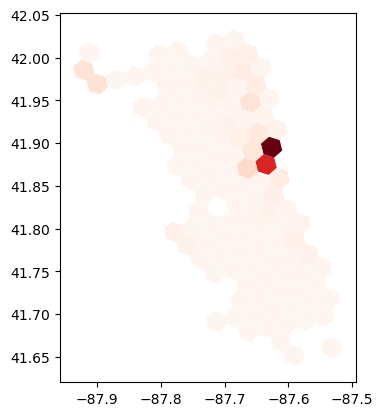

In [86]:

from shapely.geometry.polygon import Polygon

trips_starts = pd.DataFrame()
trips_starts = gdf[['h3_res_7_pickup']].groupby('h3_res_7_pickup').size().reset_index()
trips_starts.columns = ['id', 'count']
trips_starts['geometry'] = trips_starts.apply(lambda x: Polygon(h3.h3_to_geo_boundary(x["id"], geo_json=True)), axis=1)

trips_starts_geo = gpd.GeoDataFrame(trips_starts, geometry=trips_starts['geometry'], crs='EPSG:4326')
trips_starts_geo.plot(column='count', cmap='Reds')

<Axes: >

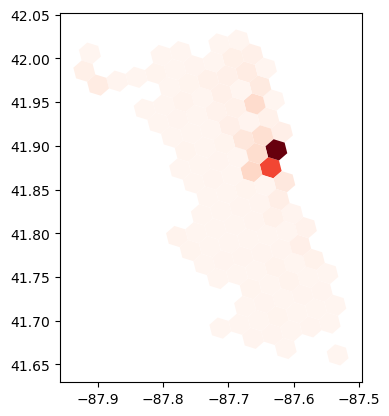

In [94]:
trips_ends = pd.DataFrame()
trips_ends = gdf[['h3_res_7_dropoff']].groupby('h3_res_7_dropoff').size().reset_index()
trips_ends.columns = ['id', 'count']
trips_ends['geometry'] = trips_ends.apply(lambda x: Polygon(h3.h3_to_geo_boundary(x["id"], geo_json=True)), axis=1)

trips_ends_geo = gpd.GeoDataFrame(trips_ends, geometry=trips_ends['geometry'], crs='EPSG:4326')
trips_ends_geo.plot(column='count', cmap='Reds')

In [112]:
 trips_ends.sort_values(by = 'count', ascending  = False).head(20)

,id,count,geometry
25,872664c1effffff,1064011,POLYGON ((-87.63048927308355 41.90755371098675...
23,872664c1affffff,635001,POLYGON ((-87.63912440648137 41.88713767856642...
46,872664ca9ffffff,163019,POLYGON ((-87.66867344075082 41.88275894341120...
22,872664c16ffffff,148802,POLYGON ((-87.6637434314177 41.960068792662646...
50,872664cadffffff,144138,POLYGON ((-87.66005281769654 41.90317532606511...
20,872664c13ffffff,134881,POLYGON ((-87.65142438552711 41.92359649212148...
49,872664cacffffff,90529,POLYGON ((-87.68099468459282 41.91921142279649...
24,872664c1bffffff,82208,"POLYGON ((-87.61820944356228 41.8710984903598,..."
99,872664d89ffffff,74656,POLYGON ((-87.65510606950835 41.98050464017767...
98,872664d88ffffff,60681,POLYGON ((-87.67608158738068 41.99655455296840...
